<a href="https://colab.research.google.com/github/FishAres/PredyNet/blob/master/Messing_around.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
try:
  %tensorflow_version 2.x
except:
  pass
  
import tensorflow as tf
import tensorflow_probability as tfp

import tensorflow.keras.layers as tkl

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import gym
import numpy as np
import time
from IPython import display

import matplotlib.pyplot as plt

%matplotlib inline

print(tf.__version__)

2.0.0-rc1


In [18]:
try:
  env = gym.make("LunarLander-v2")
except:
  !pip install box2d-py
  env = gym.make("LunarLander-v2")

env.reset()

n_act = env.action_space.n
n_obs = env.observation_space.shape[0]

     |████████████████████████████████| 450kB 10.5MB/s 


In [0]:
# collecting dataset
num_episodes = 100
env.reset()

acts =  []
act = env.action_space.sample()
acts.append(act)

obs_ = []

for i in range(num_episodes):
  env.reset()
  while True:
    if np.random.rand() > 0.8:
      act = env.action_space.sample()
    
    obs, _, done, _ = env.step(act)
    obs_.append(obs)
    acts.append(act)

    if done:
      break

obs_ = np.vstack(obs_)
acts = np.vstack(acts)[:-1,:]
acts = tf.squeeze(tf.one_hot(acts, n_act))

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((obs_))\
.batch(batch_size, drop_remainder=True)

In [0]:
class PredLayer(tf.keras.layers.Layer):
  def __init__(self, input_size=32, z_size=8):
    super(PredLayer, self).__init__()

    self.z_size = z_size
    self.input_size = input_size

    self.decoderLayer = tf.keras.Sequential([ # probably unnecessary
                          tkl.InputLayer(input_shape=(self.z_size,)),
                          tkl.Dense(input_size)
                          ])
    
    self.encoderLayer = tf.keras.Sequential([ # also unnecessary
                          tkl.InputLayer(input_shape=(self.input_size,)),
                          tkl.Dense(z_size)
                          ])

    self.y = tf.Variable(initial_value = self.init_y(),
                         trainable=False)

  def init_y(self):
    return tf.random.normal([1,self.z_size], dtype=tf.float32)

  def call(self, inputs):
    y0 = self.y
    pred = self.decoderLayer(y0)
    err = inputs - pred
    y = self.encoderLayer(err)
    return y, err, pred



In [0]:
class PredNet(tf.keras.Model):
  def __init__(self, z, input_size):
    super(PredNet, self).__init__()
    self.z_size = z
    self.input_size = input_size
    self.layer1 = PredLayer(self.input_size, self.z_size)
    self.layer2 = PredLayer(self.z_size, 6)

  def decode(self, x):
    x, _ , _ = self.layer2(x)
    _, _, pred2 = self.layer1(x)
    return pred2

  def full_pass(self, input):
    x, err1, _ = self.layer1(input)
    x, err2, _ = self.layer2(x)

    err = tf.reduce_mean(err1) + tf.reduce_mean(err2)
    return x, err, pred

In [0]:
model = PredNet(z, n_obs)

In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-3)

def compute_loss(model, inputs):
  y, err, _ = model.full_pass(inputs)
  return tf.reduce_mean(err**2)

def apply_gradients(model, inputs, optimizer, return_loss=False):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, inputs)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 
  if return_loss:
    return loss 

In [0]:
losses = []
for x_train in dataset:
  loss = apply_gradients(model, x_train, opt, return_loss=True)
  losses.append(loss)


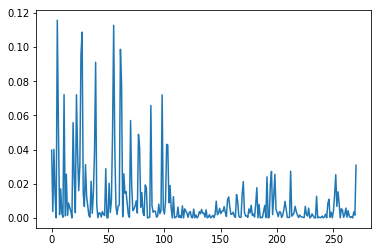

In [129]:
plt.plot(losses)

In [130]:
env.reset()
preds = []
obs_ = []
losses = []
y0 = tf.random.normal([1, z])
for epoch in range(200):
    if np.random.rand() > 0.8:
        act = env.action_space.sample()

    obs, rew, done, _ = env.step(act)

    # if epoch < 20:
    x = tf.convert_to_tensor(obs, tf.float32)
    # else:
    #   x = model.decode(y0)
    y0, err, _  = model.full_pass(x)
    pred = model.decode(y0)
    
    preds.append(pred.numpy())
    obs_.append(obs)
    losses.append(err.numpy())
    
    # loss = tf.keras.metrics.Mean()
    # loss(compute_loss(model, x, y0))
    # loss_ = loss.result()
    # losses.append(loss_)

    if done:
        env.reset()


InvalidArgumentError: ignored

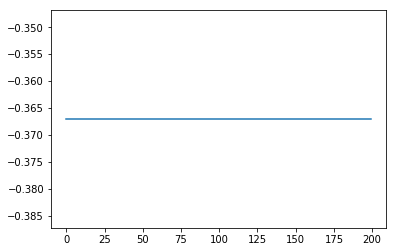

In [120]:
preds_ = np.vstack(preds)
plt.plot(preds_[:,1])

In [0]:
class PredNet(tf.keras.Model):
    "Linear Layers, no tricks"
    def __init__(self, z):
        super(PredNet, self).__init__()
        self.latent_dim = z
        
        self.decoder = tf.keras.Sequential([
            tkl.InputLayer((z,)),
            tkl.Dense(32, activation='relu'),
            tkl.Dense(64, activation='relu'),
            tkl.Dense(tfp.layers.IndependentNormal.params_size(n_obs)),
            tfp.layers.IndependentNormal(n_obs)
        ])
        
        self.encoder = tf.keras.Sequential([
            tkl.InputLayer((n_obs,)),
            tkl.Dense(32, activation='relu'),
            tkl.Dense(64, activation='relu'),
            # tkl.Reshape(target_shape=(32,1)),
            tkl.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim)),
            tfp.layers.IndependentNormal(self.latent_dim)
        ])        
        
    def decode(self, x):
        return self.decoder(x)
    
    def encode(self, x):
        return self.encoder(x)
    
    @tf.function
    def full_pass(self, x, y):
        pred = self.decode(y)
        err = x - pred
        z = self.encode(err)
        return pred, z
        

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

@tf.function
def compute_loss(model, x, y):
    pred, y = model.full_pass(x, y)
    pred = model.decode(y)
    err = x - pred
    return tf.reduce_mean(err**2)

@tf.function
def apply_gradients(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
z = 128

model = PredNet(z)
act = env.action_space.sample()
obs, rew, done, _ = env.step(act)
y0 = tf.random.normal([32,z])

def add_act(y, act):
  return tf.concat((y,act), axis=1)

In [214]:
env.reset()
preds = []
obs_ = []
losses = []
for epoch in range(100):
    start_time = time.time()
    y0 = tf.random.normal([32,z])
    epoch_loss = []
    for x_obs in dataset:
      apply_gradients(model, x_obs, y0, optimizer)   

      pred, y0 = model.full_pass(x_obs, y0)

      preds.append(pred.numpy())
      obs_.append(x_obs.numpy())
      loss = compute_loss(model, x_obs, y0).numpy()
      epoch_loss.append(np.mean(loss))
    
    epoch_loss = np.mean(epoch_loss)
    end_time = time.time()
    losses.append(epoch_loss)
    if epoch % 10 == 0:
      print("Epoch {}, Loss {}, time {}".format(epoch, epoch_loss, 
                                    np.round(end_time - start_time, 3)))

Epoch 0, Loss 0.3483443558216095, time 2.592
Epoch 10, Loss 0.1890675574541092, time 1.261
Epoch 20, Loss 0.19578775763511658, time 1.286
Epoch 30, Loss 0.19528207182884216, time 1.236
Epoch 40, Loss 0.18483944237232208, time 1.262
Epoch 50, Loss 0.19409316778182983, time 1.267
Epoch 60, Loss 0.18350471556186676, time 1.268
Epoch 70, Loss 0.1698806881904602, time 1.251
Epoch 80, Loss 0.17214515805244446, time 1.265
Epoch 90, Loss 0.17129376530647278, time 1.289


In [0]:
env.reset()
preds = []
obs_ = []
losses = []
y0 = tf.random.normal([1, z])
for epoch in range(200):
    if np.random.rand() > 0.8:
        act = env.action_space.sample()

    obs, rew, done, _ = env.step(act)

    # if epoch < 20:
    x = tf.convert_to_tensor(obs, tf.float32)
    # else:
    #   x = model.decode(y0)
    pred, y0 = model.full_pass(x, y0)

    preds.append(pred.numpy())
    obs_.append(obs)
    
    # loss = tf.keras.metrics.Mean()
    # loss(compute_loss(model, x, y0))
    # loss_ = loss.result()
    # losses.append(loss_)

    if done:
        env.reset()


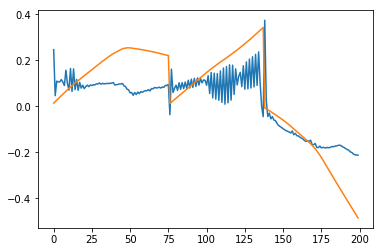

In [229]:
ind = 0
plt.plot(np.vstack(preds)[:,ind])
plt.plot(np.vstack(obs_)[:,ind])

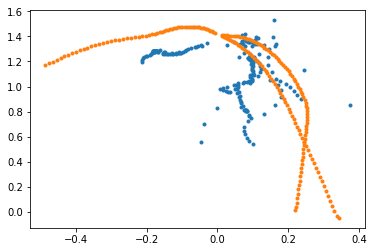

In [230]:
ps = np.vstack(preds)
obss = np.vstack(obs_)

plt.plot(ps[:,0], ps[:,1], '.')
plt.plot(obss[:,0], obss[:,1], '.')

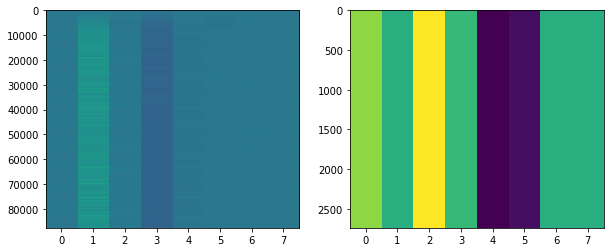

In [114]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(np.vstack(preds), aspect="auto")
plt.subplot(1,2,2)
plt.imshow(obs_, aspect="auto")

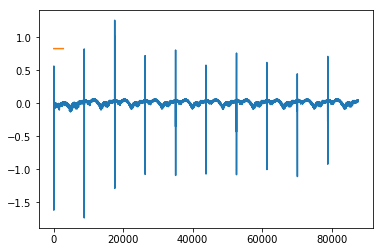

In [115]:
ind = 0
plt.plot(np.vstack(preds)[:,ind])
plt.plot(np.vstack(obs_)[:,ind])

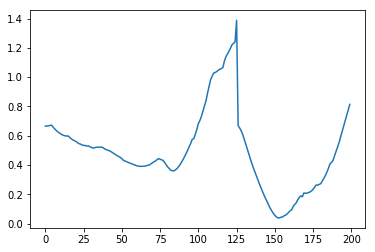

In [0]:
plt.plot(losses)

In [0]:
env.reset()
preds = []
obs_ = []
losses = []
y0 = tf.random.normal([1, z])
for epoch in range(200):
    if np.random.rand() > 0.8:
        act = env.action_space.sample()
    
    obs, rew, done, _ = env.step(act)
    
    x = tf.convert_to_tensor(obs, tf.float32)
    
    pred, y0 = model.full_pass(x, y0)
    preds.append(pred.numpy())
    obs_.append(obs)
    
    loss = tf.keras.metrics.Mean()
    loss(compute_loss(model, x, y0))
    loss_ = loss.result()
    losses.append(loss_)

    if done:
        env.reset()


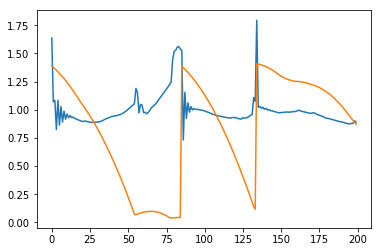

In [147]:
ind = 1
plt.plot(np.vstack(preds)[:,ind])
plt.plot(np.vstack(obs_)[:,ind])

In [118]:
R = model.weights[6].numpy()
R.shape

(1, 48)

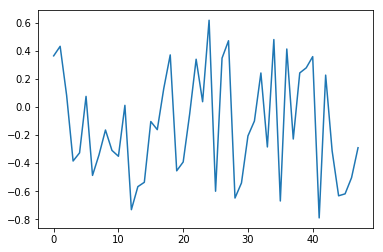

In [0]:
plt.plot(R.T);